# Human relevance

This Jupyter notebook reproduces various panels from Figure 4, which explores the TGCA BRCA/ILC datasets to determine if our mutually exclusive candidate genes (*MYH9*, *TP53BP2*, *PPP1R12A* and *PPP1R12B*) are mutated in human tumors.

In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white', {
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

from nbsupport import tcga as nb_tcga

## BRCA dataset

In the ILC dataset from Ciriello et al. (2015), *TP53BP2* and *PPP1R12A* are frequently affected by copy number gains, whilst *MYH9* shows many shallow deletions (see Figure 4a). To determine if these copy number events also affect gene expression, we would like to calculate the correlation between copy number and expression for each of these genes. Because the ILC dataset is rather small (~127 samples), we first focus on using the entire BRCA dataset (~1000 samples) to calculate the correlation. 

To do so, we first read the RNA-seq expression counts (which we previously downloaded from Firebrowse) into a dataframe. Next, this count matrix (of genes-by-samples) is processed to remove any normal samples and to rename columns to patient barcodes. To avoid confusion regarding patients with multiple samples, we remove any duplicate patient ids from the dataset. Finally, we log-transform the counts.

In [2]:
brca_expr_path = '../data/external/tcga-brca-firebrowse/rnaseqv2.normalized.txt'

brca_expr = (pd.read_csv(brca_expr_path, sep='\t', index_col=0)
               .pipe(nb_tcga.select_tumor_samples)
               .rename(columns=nb_tcga.extract_participant_barcode)
               .pipe(nb_tcga.drop_duplicate_columns)
               .pipe(lambda df: np.log2(df + 1)))

brca_expr.head()

,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,TCGA-A1-A0SD,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
A1BG,7.630010,7.897146,8.728725,7.585096,8.076179,7.677873,7.729932,8.300051,5.649592,7.162871,...,5.496785,8.33528,10.012705,9.060797,6.916604,8.883514,7.808774,8.000758,8.783137,7.961896
A1CF,0.000000,0.000000,0.931002,0.000000,0.511468,0.000000,0.000000,0.606916,0.000000,0.000000,...,0.484602,0.00000,0.000000,0.560324,0.000000,0.000000,0.000000,1.749234,0.000000,0.000000
A2BP1,0.000000,0.000000,0.000000,0.000000,2.271963,0.665938,0.000000,0.606916,2.460743,0.412294,...,0.000000,0.00000,0.692249,2.637077,2.519013,0.000000,0.478920,1.273277,0.675635,0.000000
A2LD1,6.699932,6.167209,7.342165,5.988848,7.279566,6.814235,6.686112,7.874177,5.281557,6.084553,...,7.568796,7.82078,6.979354,5.923986,8.290288,5.971102,7.046887,6.338587,6.362838,4.710757
A2ML1,1.250113,2.419593,0.000000,1.408658,2.138913,1.119821,2.343408,0.000000,2.054328,3.105846,...,7.177123,0.00000,4.088464,1.277271,0.000000,2.909965,0.478920,5.826276,1.760987,2.371754


For the CNV data, we apply similar pre-processing steps, resulting in a genes-by-samples matrix of copy number calls.

In [3]:
brca_cnv_path = '../data/external/tcga-brca-firebrowse/gistic.all_thresholded.by_genes.txt'
brca_cnv = (pd.read_csv(brca_cnv_path, sep='\t', index_col=0)
              .drop(['Locus ID', 'Cytoband'], axis=1)
              .pipe(nb_tcga.select_tumor_samples)
              .rename(columns=nb_tcga.extract_participant_barcode)
              .pipe(nb_tcga.drop_duplicate_columns))

brca_cnv.head()

,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,TCGA-A1-A0SD,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
ACAP3,0,-1,-1,0,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ACTRT2,0,-1,-1,0,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
AGRN,0,-1,-1,0,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ANKRD65,0,-1,-1,0,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0
ATAD3A,0,-1,-1,0,0,0,0,-1,0,-1,...,0,-1,0,0,-1,-1,0,-1,-1,0


Next, we subset both datasets to their set of common samples. This leaves us with a total of 1068 samples.

In [4]:
common_samples = set(brca_expr.columns) & set(brca_cnv.columns)

brca_expr = brca_expr[list(common_samples)]
brca_cnv = brca_cnv[list(common_samples)]

brca_expr.shape

(20502, 1068)

Finally, we plot the correlation between copy number and expression for each of our candidate genes. Due to the large number of samples in the BRCA dataset, we don't plot the individual data points.

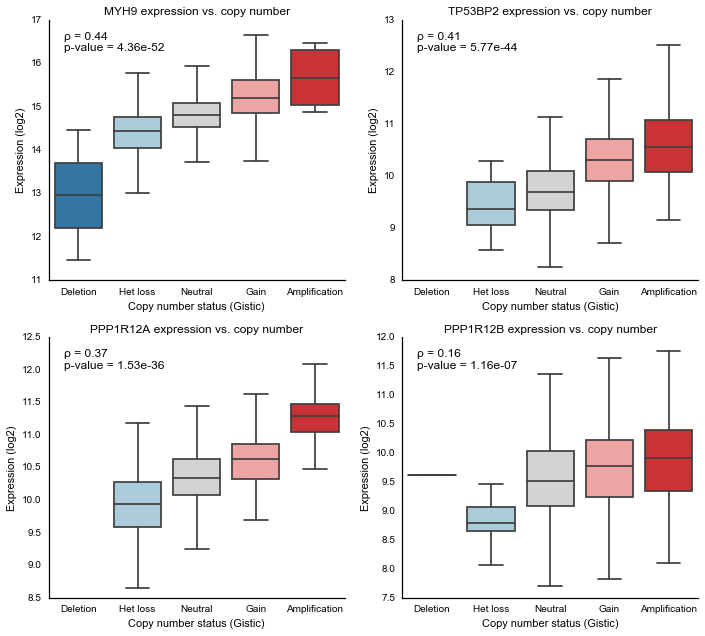

In [5]:
# Plot for notebook.
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
genes = ['MYH9', 'TP53BP2', 'PPP1R12A', 'PPP1R12B']

for gene, ax in zip(genes, axes.flatten()):
    nb_tcga.plot_cnv_expr_corr(
        brca_expr, brca_cnv, gene_name=gene,
        ax=ax, show_points=False)
    
fig.tight_layout()

# Draw again for paper.
genes = ['MYH9', 'TP53BP2', 'PPP1R12A', 'PPP1R12B']

for gene in genes:
    with sns.plotting_context('paper', font_scale=0.7):
        fig, ax = plt.subplots(figsize=(2.2, 1.7))
        nb_tcga.plot_cnv_expr_corr(
            brca_expr, brca_cnv, gene_name=gene,
            ax=ax, show_points=False, 
            boxplot_kws={'linewidth': 0.5},
            label_kws={'fontsize': 5})
        
        ax.set_xlabel('')
        ax.set_title('')
        ax.set_xticklabels(['Deletion', 'Het loss', 'Neutral',
                            'Gain', 'Ampl.'])
        
    fig.savefig('../reports/figures/fig_4_{}.pdf'
                .format(gene.lower()), bbox_inches='tight')
    plt.close(fig)

This shows significant correlation for all four genes, with the strongest correlation for *MYH9*, *TRP53BP2* and *PPP1R12A*. The expression of *PPP1R12B* is less strongly correlated, although the observed correlation is still significant.